<a href="https://colab.research.google.com/github/ipavlopoulos/modern_nlp/blob/main/ModernNLP_S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ModernNLP: #1
* Talk about word usage change and this recent [Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora](https://www.aclweb.org/anthology/2020.acl-main.51.pdf).
* As background, read Mikolov's [ICLR](https://research.google/pubs/pub41224/) and [NIPS](https://papers.nips.cc/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html) papers, and alingment models such as [Procrustes](https://www.aclweb.org/anthology/K18-1021.pdf) and [Compass](https://arxiv.org/abs/1906.02376).
* Whoever interested take a look [subword embeddings](https://www.aclweb.org/anthology/P16-1162.pdf). 
* Import Gensim's Word2Vec.

Adapted from:
```
John Pavlopoulos, Senior Lecturer (fixed-term) 
Stockholm University, Sweden
```

By:
```
Guilherme Dinis J., Phd Candidate
Stockholm University, Sweden
```




---



## Context

We are studying the method proposed by Gonen, et. al to measure word change usage between corpora, through their embeddings.
Their approach is based on comparing nearest neighbours - the hypothesis being that if words remain the same, their neighbors will also be the same, but if they change in usage, then so will their neighbours.

The paper notes that the more neighbours used, the more "stable" the similarity is between neighbours.
However, there is another factor at play here: term frequency.

Very frequent words, especially sentence building words (e.g. prepositions) will likely have the same neighbours at low K, and decrease it as we increase K - e.g. (from, the).
Though before decreasing, the similarity might increase, since other common words can appear in the set.

The infrequent words, on the other hand, should show opposite behavior - their rarity means that they can appear next to different terms.
So in terms of pair frequency, there can be a few other terms considered NN, but with a small frequency, i.e. [(a, b), 1].

This pattern would likely also be apparent if we were to use the frequency of the words directly to compute nearest neighbours - instead of the embeddings.
And it's easy to observe when comparing a corpus against itself.

The question is: for corpora where usage has actually changed, what would be observe?
It's likekly that moderately frequent words (that have changed) would show a pettern of having fewer common NN, and the overlap would increase as we increase K - i.e. they would behave as infrequent words do when comparing the same corpora.

This notebooks shows this pattern for the Brown dataset - when using embeddings.

In [1]:
%%capture
from gensim.models import word2vec
from gensim import models
from gensim import corpora
import logging
import nltk
from nltk.corpus import brown
import multiprocessing as mp
from typing import List, Sequence, Mapping, Tuple, Any, Tuple
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib as mpl

import collections

In [2]:
%matplotlib inline

Import NLTK and download the Brown corpus. 

In [3]:
nltk.download('brown')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
print(brown.sents()[0])

['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', "Atlanta's", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', "''", 'that', 'any', 'irregularities', 'took', 'place', '.']


In [5]:
def generate_embeddings(
    corpus: List[List[str]], num_spaces: int, vector_size: int = 100, negative: int = 5
) -> List[Any]:
    spaces = []
    # different spaces
    for i in range(num_spaces):
        space = word2vec.Word2Vec(
            corpus, vector_size=vector_size, negative=negative, seed=i, workers=mp.cpu_count()
        )
        spaces.append(space)
    return spaces

In [6]:
def word_neighbors(
  target: str, topn: int, spaces: List[word2vec.Word2Vec]
) -> Mapping[int, Sequence[Tuple[str, float]]]:
  # the neighbors
  neighbors = {}
  for i, space in enumerate(spaces):
    neighbors[i] = space.wv.most_similar(positive=[target], topn=topn)
  return neighbors

In [7]:
def create_word_frequency(words: List[str]) -> corpora.Dictionary:
    return collections.Counter(words)

In [8]:
spaces = generate_embeddings(corpus=brown.sents(), num_spaces=10)


2021-04-20 22:11:10,939 : INFO : PROGRESS: at sentence #40000, processed 888291 words, keeping 49136 word types
2021-04-20 22:11:11,457 : INFO : PROGRESS: at sentence #50000, processed 1039920 words, keeping 53024 word types
2021-04-20 22:11:11,887 : INFO : collected 56057 word types from a corpus of 1161192 raw words and 57340 sentences
2021-04-20 22:11:11,887 : INFO : Creating a fresh vocabulary
2021-04-20 22:11:12,016 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 retains 15173 unique words (27.067092423782935%% of original 56057, drops 40884)', 'datetime': '2021-04-20T22:11:12.016491', 'gensim': '4.0.1', 'python': '3.7.5 (default, Nov  6 2019, 22:15:04) \n[Clang 11.0.0 (clang-1100.0.33.8)]', 'platform': 'Darwin-20.3.0-x86_64-i386-64bit', 'event': 'prepare_vocab'}
2021-04-20 22:11:12,017 : INFO : Word2Vec lifecycle event {'msg': 'effective_min_count=5 leaves 1095086 word corpus (94.30705688637194%% of original 1161192, drops 66106)', 'datetime': '2021-04-20T22:11:

In [9]:

def neighbour_overlap(v1, v2):
  """Overlap between two lists. Each element is a 2-tuple of (word, score)."""
  assert len(v1) == len(v2)
  pool = set([word for word, _ in v2])
  return len([1 for (w1, _), _ in zip(v1, v2) if w1 in pool])/len(v1)

def score(v1, v2):
  assert len(v1) == len(v2)
  pool = set([word for word, _ in v2])
  return -len([1 for (w1, _), _ in zip(v1, v2) if w1 in pool])


def vocabulary_overlap(neighbors: Mapping[int, Sequence[Tuple[str, float]]], minn: int, maxn: int) -> List[float]:
  """
  Computes the overlap between sets of neibhors.
  The number of neihbors used varies from minn to maxn.
  """
  mean_overlaps = []
  all_overlaps = {}
  for n in range(minn, maxn + 1):
    # compute similarities
    for i in range(len(neighbors)):
      for j in range(len(neighbors)):
        if i < j: 
          # compare only the top n items in the lists
          overlap = neighbour_overlap(neighbors[i][:n], neighbors[j][:n])
          all_overlaps[(i, j)] = overlap
          all_overlaps[(j, i)] = overlap
    
    overlaps = []
    for i in range(len(neighbors)):  
      ij_overlaps = []
      for j in range(len(neighbors)):
        if i != j:
          ij_overlaps.append(all_overlaps[(i, j)])
      overlaps.append(np.mean(ij_overlaps))
    mean_overlaps.append(np.mean(overlaps))
  return mean_overlaps



In [10]:
def plot_and_show_overlaps(word: str, spaces: List[Any], topn: int, minn: int, maxn: int) -> None:
    neighbors = word_neighbors(target=word, topn=topn, spaces=spaces)
    mean_overlaps = vocabulary_overlap(neighbors, minn=minn, maxn=maxn)

    # Plot the mean relative overlap of a word with its self (self-similarity), 
    # for a varying number of neighbors.
    pd.DataFrame({"self similariry": mean_overlaps}).plot();
    top10 = pd.DataFrame({i:[n[0] for n in neighbors[i][:10]] for i in neighbors})
    top10.head()



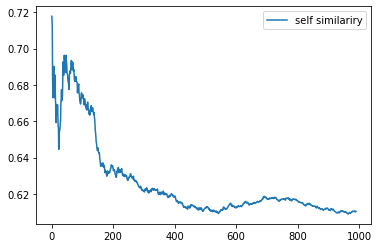

In [11]:
plot_and_show_overlaps(word="house", spaces=spaces, topn=1000, minn=10, maxn=1000)

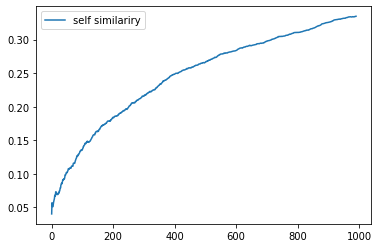

In [12]:
plot_and_show_overlaps(word="gay", spaces=spaces, topn=1000, minn=10, maxn=1000)

In [13]:
# get the mean overlap for top K NN, for a set of words
def words_nn_overlaps(words: List[str], spaces: List[Any], topn: int, minn: int, maxn: int) -> List[List[float]]:
    results = []
    for word in words:
        neighbors = word_neighbors(target=word, topn=topn, spaces=spaces)
        mean_overlaps = vocabulary_overlap(neighbors, minn=minn, maxn=maxn)
        results.append(mean_overlaps)
    return results

In [14]:
# plot the mean overlap for a set of words
def plot_words_nn_overlaps(words: List[str], words_overlaps: List[List[float]]) -> Any:
    fig, ax = plt.subplots(figsize=(12, 8))
    for word, overlaps in zip(words, words_overlaps):
        plt.plot(overlaps, label=word)
    ax.set_title("Word Overlaps")
    ax.legend()


## Comparing Frequent, Infrequent, and Middle Words

In [15]:
word_frequency = create_word_frequency(brown.words())

In [16]:
def compute_and_plot_overlaps(words: List[str], spaces: List[Any], topn: int, minn: int, maxn: int):
    overlaps = words_nn_overlaps(
        words, spaces=spaces, topn=topn, minn=minn, maxn=maxn
    )
    plot_words_nn_overlaps(words=words, words_overlaps=overlaps)

In [17]:
def get_word_counts(word_frequency: collections.Counter, n: int, mode: str, min_count: int):
    if mode == "top":
        return [(word, count) for word, count in word_frequency.most_common(n=10) if count >= min_count]
    elif mode == "bottom":
        results = []
        for word, count in reversed(word_frequency.most_common()):
            if count >= min_count:
                results.append((word, count))
            if len(results) >= n:
                break
        return results
    elif mode == "middle":
        results = []
        # filter min count first
        most_common = [(word, count) for word, count in word_frequency.most_common() if count >= min_count]
        unique_frequency = sorted(set([count for _, count in most_common]))
        mid_value_index = int(len(unique_frequency) * 0.5)
        start_index = int(mid_value_index - n / 2)
        mid_values = [unique_frequency[i] for i in range(start_index, start_index + n)]
        # find words with mid_values count
        for mid_value in mid_values:
            for i in range(len(most_common)):
                word, count = most_common[i]
                if count == mid_value:
                    results.append((word, count))
                    break
        return results


### Frequent Terms

In [18]:
most_frequent_words_count = get_word_counts(word_frequency, n=10, mode="top", min_count=10)
most_frequent_words = [word for word, _ in most_frequent_words_count]

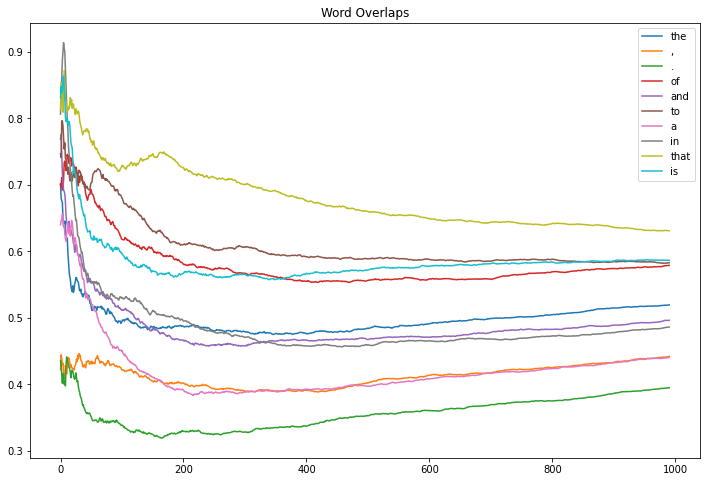

In [19]:
compute_and_plot_overlaps(most_frequent_words, spaces=spaces, topn=1000, minn=10, maxn=1000)

### Infrequent Terms

In [20]:
least_frequent_words_count = get_word_counts(word_frequency, n=10, mode="bottom", min_count=10)
least_frequent_words = [word for word, _ in least_frequent_words_count]

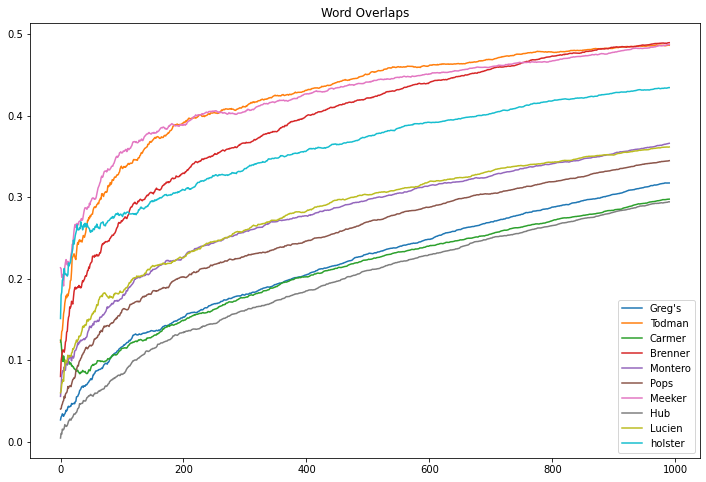

In [21]:
compute_and_plot_overlaps(least_frequent_words, spaces=spaces, topn=1000, minn=10, maxn=1000)

### Middle Words

In [22]:
middle_words_count = get_word_counts(word_frequency, n=10, mode="middle", min_count=10)
middle_words = [word for word, _ in middle_words_count]

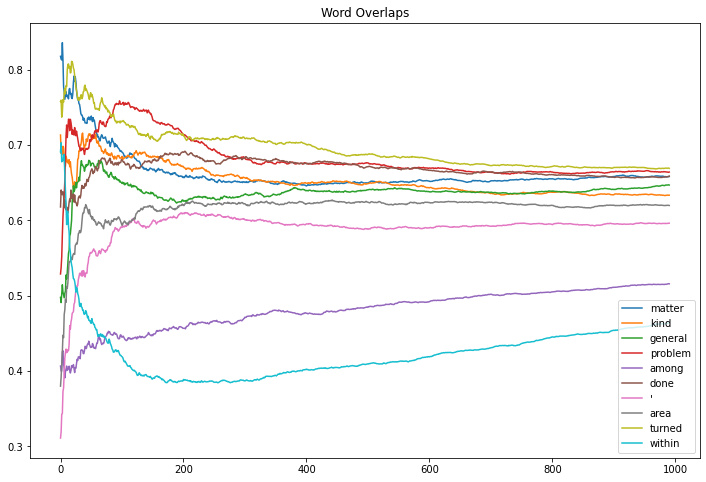

In [23]:
compute_and_plot_overlaps(middle_words, spaces=spaces, topn=1000, minn=10, maxn=1000)

In [24]:
middle_words_count

[('matter', 306),
 ('kind', 310),
 ('general', 311),
 ('problem', 312),
 ('among', 314),
 ('done', 316),
 ("'", 317),
 ('area', 319),
 ('turned', 320),
 ('within', 321)]

By looking at the words in the middle, we can see the transition from more common to less common NN of frequent terms, and the transition from less common to more common NN for infrequent terms as K increases.

Because we are comparing the same corpus here, what we would expect to observe is that the top K neighbours for infrequent terms should be the same - in fact, some words might only appear once next to two other words - (W2V ran with a limit of 1 occurence).
Since we're using embeddings, these low frequency terms will have fewer (gradient) updates - so our estimates of their consine distance to other terms should be less certain - hence, we can easily find lower overlap across embeddings.
In our plots, we're using words that appear at least 10 times.

## Comparing Different Corpora

In [25]:
from nltk.corpus import comtrans

In [26]:
len(comtrans.words())

1978268

In [27]:
comtrans_word_frequency = create_word_frequency(comtrans.words())

In [28]:
cmrw = set(comtrans.words())

In [29]:

for token, count in middle_words_count:
    print(f"{token}({count}) is present in Reviews: {token in cmrw}, count - {comtrans_word_frequency[token]}")
    

matter(306) is present in Reviews: True, count - 375
kind(310) is present in Reviews: True, count - 182
general(311) is present in Reviews: True, count - 190
problem(312) is present in Reviews: True, count - 385
among(314) is present in Reviews: True, count - 93
done(316) is present in Reviews: True, count - 310
'(317) is present in Reviews: True, count - 2622
area(319) is present in Reviews: True, count - 399
turned(320) is present in Reviews: True, count - 18
within(321) is present in Reviews: True, count - 533


In [30]:
comtrans_spaces = generate_embeddings(corpus=comtrans.sents(), num_spaces=1)

2021-04-20 22:16:12,846 : INFO : collecting all words and their counts
2021-04-20 22:16:12,947 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-04-20 22:16:13,774 : INFO : PROGRESS: at sentence #10000, processed 197419 words, keeping 17580 word types
2021-04-20 22:16:14,601 : INFO : PROGRESS: at sentence #20000, processed 398368 words, keeping 26992 word types
2021-04-20 22:16:15,535 : INFO : PROGRESS: at sentence #30000, processed 599981 words, keeping 34143 word types
2021-04-20 22:16:16,356 : INFO : PROGRESS: at sentence #40000, processed 793831 words, keeping 37714 word types
2021-04-20 22:16:17,453 : INFO : PROGRESS: at sentence #50000, processed 986006 words, keeping 38457 word types
2021-04-20 22:16:18,419 : INFO : PROGRESS: at sentence #60000, processed 1178130 words, keeping 39291 word types
2021-04-20 22:16:20,027 : INFO : PROGRESS: at sentence #70000, processed 1372358 words, keeping 44934 word types
2021-04-20 22:16:20,797 : INFO : PROGRESS: a

In [31]:
# similar absolute frequency
pd.DataFrame(
    word_neighbors(target="matter", topn=10, spaces=[spaces[0]] + comtrans_spaces)
)

,0,1
0,"(reason, 0.9032223224639893)","(issue, 0.939996600151062)"
1,"(question, 0.8842293620109558)","(document, 0.9107477068901062)"
2,"(true, 0.8737044334411621)","(measure, 0.9087477922439575)"
3,"(thing, 0.8664104342460632)","(subject, 0.9031268358230591)"
4,"(problem, 0.865149199962616)","(task, 0.8997346758842468)"
5,"(idea, 0.8637709021568298)","(idea, 0.8959574103355408)"
6,"(evidence, 0.8585220575332642)","(step, 0.8921494483947754)"
7,"(sort, 0.8556677103042603)","(problem, 0.8837388753890991)"
8,"(means, 0.8450469970703125)","(goal, 0.8747774958610535)"
9,"(truth, 0.839006781578064)","(approach, 0.8746033906936646)"


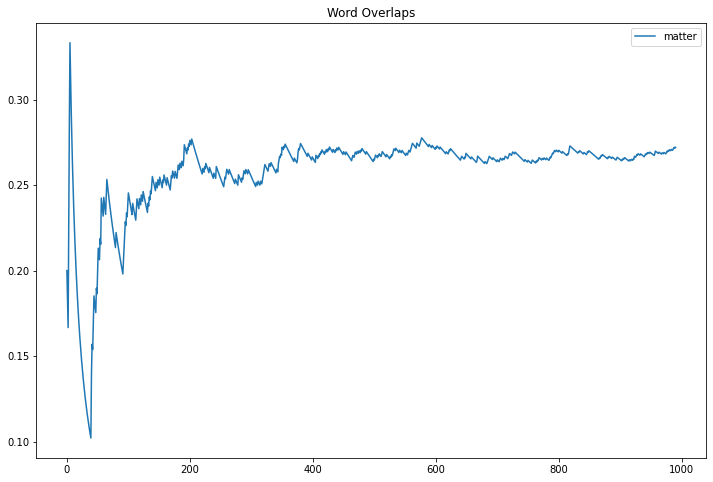

In [32]:
compute_and_plot_overlaps(["matter"], spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

In [33]:
# reduced absolute frequency
pd.DataFrame(
    word_neighbors(target="among", topn=10, spaces=[spaces[0]] + comtrans_spaces)
)

,0,1
0,"(within, 0.8081161379814148)","(including, 0.9201706647872925)"
1,"(Among, 0.8023341298103333)","(amongst, 0.9146216511726379)"
2,"(ways, 0.7879992723464966)","(involving, 0.8927226066589355)"
3,"(warts, 0.7633574604988098)","(young, 0.8866342902183533)"
4,"(counterparts, 0.759552538394928)","(around, 0.8838255405426025)"
5,"(parts, 0.7505455017089844)","(across, 0.8742950558662415)"
6,"(skills, 0.7490447163581848)","(outside, 0.8726495504379272)"
7,"(members, 0.7448262572288513)","(diplomatic, 0.8675886988639832)"
8,"(types, 0.7372753620147705)","(disasters, 0.8673170208930969)"
9,"(myriad, 0.7343860864639282)","(containing, 0.8589165806770325)"


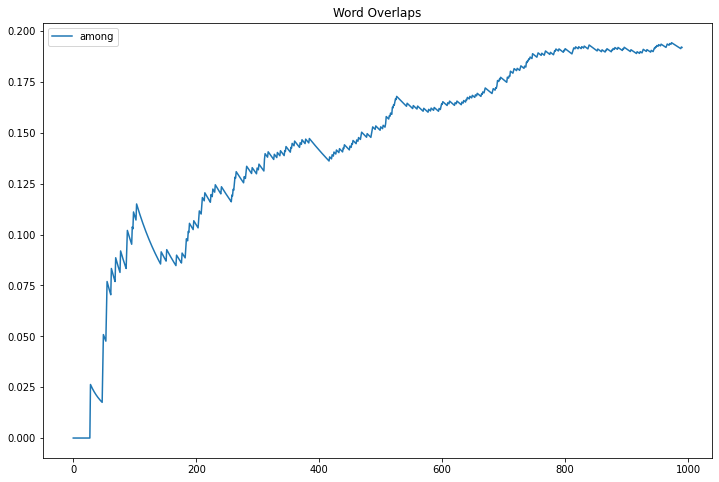

In [34]:
compute_and_plot_overlaps(["among"], spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

In [35]:
# increased absolute frequency
pd.DataFrame(
    word_neighbors(target="within", topn=10, spaces=[spaces[0]] + comtrans_spaces)
)

,0,1
0,"(under, 0.8271770477294922)","(between, 0.9077411890029907)"
1,"(throughout, 0.8203385472297668)","(under, 0.9054354429244995)"
2,"(between, 0.8157199025154114)","(outside, 0.9034969806671143)"
3,"(among, 0.8081161975860596)","(concerning, 0.8877198100090027)"
4,"(With, 0.7965531945228577)","(throughout, 0.8861013650894165)"
5,"(for, 0.7736618518829346)","(across, 0.8740765452384949)"
6,"(Within, 0.7697821259498596)","(regarding, 0.8735118508338928)"
7,"(beyond, 0.7665056586265564)","(through, 0.8612585067749023)"
8,"(major, 0.7654470801353455)","(National, 0.8610411286354065)"
9,"(outlines, 0.7627434134483337)","(behind, 0.8567283749580383)"


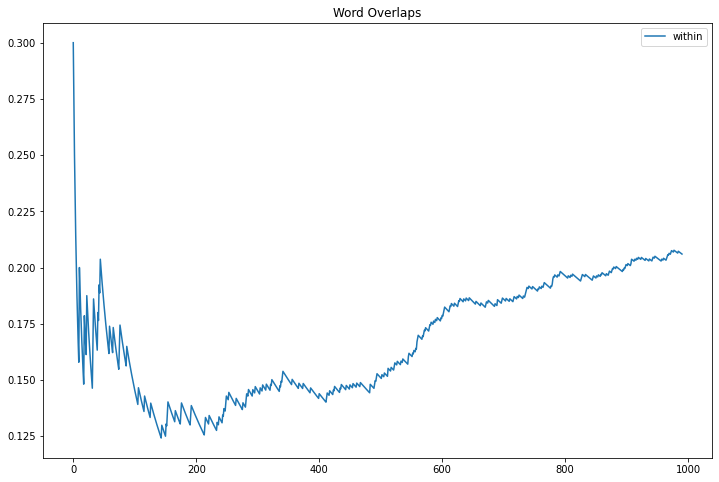

In [36]:
compute_and_plot_overlaps(["within"], spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

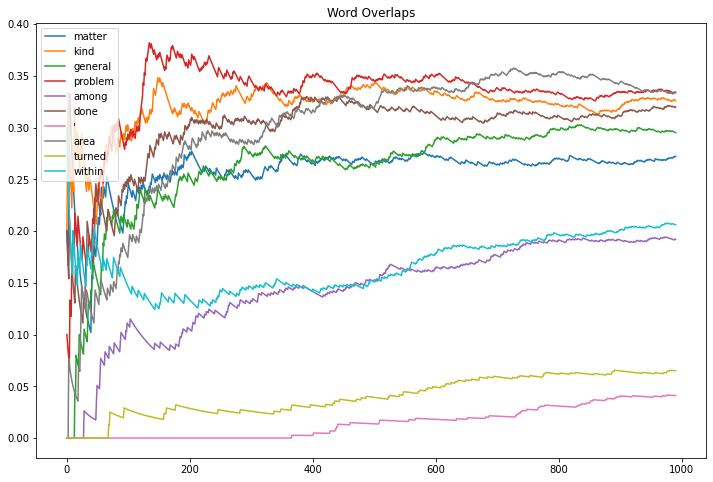

In [37]:
compute_and_plot_overlaps(middle_words, spaces=[spaces[0]] + comtrans_spaces, topn=1000, minn=10, maxn=1000)

For middle words from the Brown dataset, the pattern differs at low values of K, but shows the trend of going from low overlap to an increase in overlap - even for tokens with virtually no overlap at low values of K.

The differences lie at the smaller K:

  - Words infrequent in one set will have low overlap (at low K).
  - Words moderately or highly on both sets will have higher overlap (at low K).

Inspecting the words, we see dissimilarity. But it is difficult to judge without comparing other NN words - especially for terms with a high count of neighours having moderate frequency each in the corpus, which can have several potential candidate NN whose promximity will vary slightly (e.g. due to noise in generating the embeddings).


In summary:

  - With this method, frequency of terms (and their neighbours) appears to have a very high impact on overlap
  - Overlap might not even hold for the same words across embeddings due to randomization, and frequency of other terms in the dataset
  - The stability of similarity that is observed at very large K is likely due to overlap between terms in the corpus - hence not indicative of stability of the method itself.


Determing if a word's usage is the same would, in theory from the NN principle, imply that the word would have to share the same neighbours - and the occurence of the word and its neighbours ought to be relatively the same between corpora.
But as we have seen, both rare and high frequency can be misinterpreted - the former
because of label bias and the latter for having a larger pool of "NN" in the embedding space.
It would be interesting to study how the change in the frequency use of a neighbour would affect the overlap of a
word under consideration; and how the method behaves when actual word frequencies are used instead of embeddings (i.e. counting neighbors to determine NN).